
# Notebook Assignment 1: Data Prep Methods & RMSE Impact Study
_Outliers · Missingness · Encoding · Transforms · Binning_

**Goal:** Demonstrate, **one method per section**, how classic data preparation techniques change downstream **Linear Regression** performance.  
After each method:
1) Fit stats **on TRAIN only**,  
2) Transform **train/valid/test consistently**,  
3) Train **LinearRegression**,  
4) Print & log **RMSE (train/valid/test)** (+ MAE, R² optional),  
5) Append a row to a shared **results tracker**.

> ✅ Dataset placeholder: You will **upload / point to a CSV** in the next cell (variable `DATA_CSV_PATH`).  
> ✅ Split once: **60/20/20** with fixed `RANDOM_SEED`.


## 1) Imports, Seeding, Small Utilities

In [34]:

# Core
import math, warnings, sys, os, gc
import numpy as np
import pandas as pd

# Modeling & preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualization (matplotlib only; no seaborn)
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# --- Reproducibility ---
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# --- Small helpers ---
def rmse(model, X, y):
    preds = model.predict(X)
    return root_mean_squared_error(y, preds, squared=False)

def mae(model, X, y):
    preds = model.predict(X)
    return mean_absolute_error(y, preds)

def r2(model, X, y):
    preds = model.predict(X)
    return r2_score(y, preds)

def evaluate_and_log(method_name, Xtr, ytr, Xva, yva, Xte, yte, results_df):
    lr = LinearRegression()
    lr.fit(Xtr, ytr)
    row = {
        "method": method_name,
        "n_features_after_prep": Xtr.shape[1],
        "rmse_train": rmse(lr, Xtr, ytr),
        "rmse_valid": rmse(lr, Xva, yva),
        "rmse_test":  rmse(lr, Xte, yte),
        "mae_valid":  mae(lr, Xva, yva),
        "r2_valid":   r2(lr, Xva, yva),
    }
    print(row)
    results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
    return results_df, lr

def detect_column_types(df, target_col):
    # Basic type detection
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Try to find datetime-like columns
    dt_cols = []
    for c in df.columns:
        if c == target_col: 
            continue
        if c in num_cols or c in cat_cols:
            continue
        try:
            parsed = pd.to_datetime(df[c], errors='raise', infer_datetime_format=True)
            dt_cols.append(c)
        except Exception:
            pass
    # Also scan object columns that might be datetime
    for c in list(cat_cols):
        try:
            parsed = pd.to_datetime(df[c], errors='raise', infer_datetime_format=True)
            dt_cols.append(c)
            cat_cols.remove(c)
        except Exception:
            pass

    # Deduplicate
    dt_cols = list(dict.fromkeys(dt_cols))
    # Remove dt from num if mistakenly included
    num_cols = [c for c in num_cols if c not in dt_cols]

    return num_cols, cat_cols, dt_cols

def safe_log1p(x):
    # Safely handle non-positive values by shifting
    x = np.asarray(x, dtype=float)
    minx = np.nanmin(x)
    shift = 1.0 - minx if minx <= 0 else 0.0
    return np.log1p(x + shift)

print("Setup complete.")


Setup complete.


## 2) Data Load + Single Split (60/20/20)

In [35]:

# === PLACEHOLDER: point to your CSV here ===
# Example: DATA_CSV_PATH = "BigMart_Train.csv"
DATA_CSV_PATH = "train_v9rqX0R.csv"   # <-- Replace with your CSV
TARGET_COL = "Item_Outlet_Sales"                      # <-- Replace with your target column name

# You can use a simple file uploader in notebook environments like Colab/JupyterLab:
# from google.colab import files
# uploaded = files.upload()
# DATA_CSV_PATH = list(uploaded.keys())[0]

# --- Load ---
df = pd.read_csv(DATA_CSV_PATH)

assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found in CSV. Please set TARGET_COL correctly."

# --- Optional: Light cleaning of obvious all-NA columns ---
all_na_cols = [c for c in df.columns if df[c].isna().all()]
if all_na_cols:
    print("Dropping all-NA columns:", all_na_cols)
    df = df.drop(columns=all_na_cols)

# --- Split: 60/20/20 ---
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=RANDOM_SEED)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=RANDOM_SEED)

ytr, yva, yte = df_train[TARGET_COL], df_valid[TARGET_COL], df_test[TARGET_COL]

# Detect column types (will be reused by methods)
num_cols, cat_cols, dt_cols = detect_column_types(df, TARGET_COL)

print("Shapes:", df_train.shape, df_valid.shape, df_test.shape)
print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols), "| Datetime-like cols:", len(dt_cols))


Shapes: (5113, 12) (1705, 12) (1705, 12)
Numeric cols: 4 | Categorical cols: 7 | Datetime-like cols: 0


## 3) Baseline: Raw Linear Regression (no scaling/encoding)

In [36]:

# Keep only numeric features available as-is (no encoding/scaling)
Xtr_base = df_train[num_cols].copy()
Xva_base = df_valid[num_cols].copy()
Xte_base = df_test[num_cols].copy()

# Drop columns with any missing values (raw baseline, strict)
cols_no_na = [c for c in num_cols if df_train[c].notna().all() and df_valid[c].notna().all() and df_test[c].notna().all()]
Xtr_b = Xtr_base[cols_no_na]
Xva_b = Xva_base[cols_no_na]
Xte_b = Xte_base[cols_no_na]

results_df = pd.DataFrame(columns=["method","n_features_after_prep","rmse_train","rmse_valid","rmse_test","mae_valid","r2_valid"])
results_df, _ = evaluate_and_log("Baseline (raw LR, numeric only, drop-NA cols)", Xtr_b, ytr, Xva_b, yva, Xte_b, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

## 4) Outlier Handling — Visual Inspection (Boxplot / Scatter)

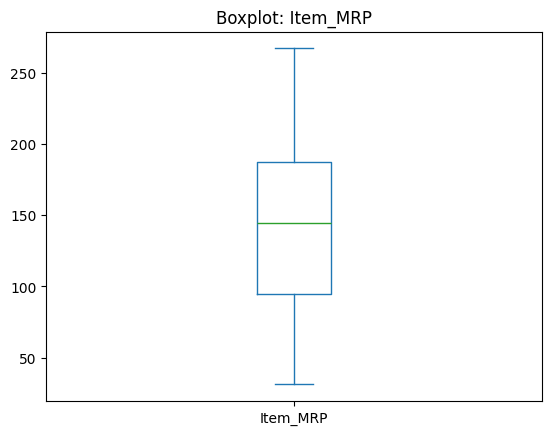

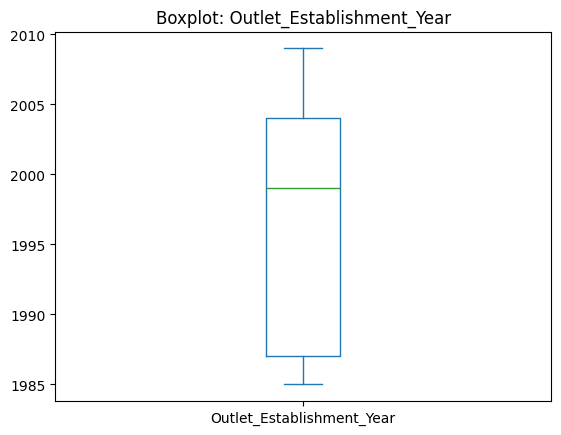

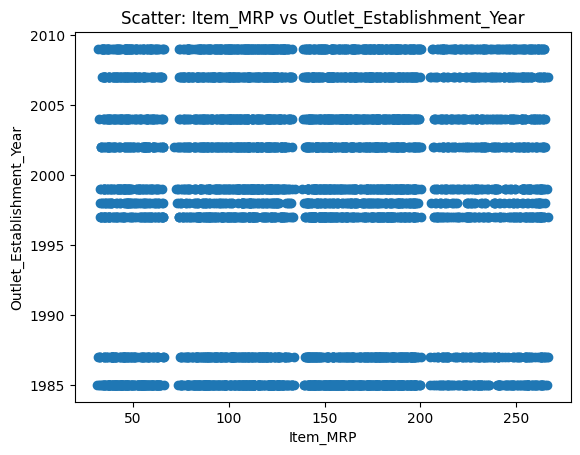

In [8]:

# Visuals for a couple of numeric columns (picked heuristically: top-variance features)
# NOTE: This is *exploratory* (no transformation). Add your brief comments after viewing.
if len(num_cols) > 0:
    variances = df_train[num_cols].var().sort_values(ascending=False)
    top_cols = variances.index[:2].tolist()
    for c in top_cols:
        plt.figure()
        df_train[c].plot(kind='box', title=f"Boxplot: {c}")
        plt.show()

    if len(top_cols) == 2:
        plt.figure()
        plt.scatter(df_train[top_cols[0]], df_train[top_cols[1]])
        plt.title(f"Scatter: {top_cols[0]} vs {top_cols[1]}")
        plt.xlabel(top_cols[0]); plt.ylabel(top_cols[1])
        plt.show()
else:
    print("No numeric columns available for visual inspection.")


### Z-Score Rule (cap outliers at ±3σ) -> LR + RMSE

In [9]:

def fit_zscore_params(df, numeric_cols):
    means = df[numeric_cols].mean()
    stds = df[numeric_cols].std().replace(0, np.nan)
    return means, stds

def apply_zscore_cap(df, numeric_cols, means, stds, z=3.0):
    out = df.copy()
    for c in numeric_cols:
        m, s = means[c], stds[c]
        if pd.isna(s) or s == 0:
            continue
        lower, upper = m - z*s, m + z*s
        out[c] = out[c].clip(lower, upper)
    return out

means, stds = fit_zscore_params(df_train, num_cols)
Xtr = apply_zscore_cap(df_train[num_cols], num_cols, means, stds, z=3.0)
Xva = apply_zscore_cap(df_valid[num_cols], num_cols, means, stds, z=3.0)
Xte = apply_zscore_cap(df_test[num_cols],  num_cols, means, stds, z=3.0)

# Fill remaining NA with train mean (to allow LR)
mean_imputer = SimpleImputer(strategy='mean')
Xtr_i = pd.DataFrame(mean_imputer.fit_transform(Xtr), columns=num_cols, index=Xtr.index)
Xva_i = pd.DataFrame(mean_imputer.transform(Xva),   columns=num_cols, index=Xva.index)
Xte_i = pd.DataFrame(mean_imputer.transform(Xte),   columns=num_cols, index=Xte.index)

results_df, _ = evaluate_and_log("Outlier: Z-Score cap (±3σ) + mean impute", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### IQR Rule (cap at [Q1-1.5*IQR, Q3+1.5*IQR]) -> LR + RMSE

In [10]:

def fit_iqr_params(df, numeric_cols):
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    return Q1, Q3, IQR

def apply_iqr_cap(df, numeric_cols, Q1, Q3, IQR, whisk=1.5):
    out = df.copy()
    lower = Q1 - whisk * IQR
    upper = Q3 + whisk * IQR
    for c in numeric_cols:
        out[c] = out[c].clip(lower[c], upper[c])
    return out

Q1, Q3, IQR = fit_iqr_params(df_train, num_cols)
Xtr = apply_iqr_cap(df_train[num_cols], num_cols, Q1, Q3, IQR, 1.5)
Xva = apply_iqr_cap(df_valid[num_cols], num_cols, Q1, Q3, IQR, 1.5)
Xte = apply_iqr_cap(df_test[num_cols],  num_cols, Q1, Q3, IQR, 1.5)

mean_imputer = SimpleImputer(strategy='mean')
Xtr_i = pd.DataFrame(mean_imputer.fit_transform(Xtr), columns=num_cols, index=Xtr.index)
Xva_i = pd.DataFrame(mean_imputer.transform(Xva),   columns=num_cols, index=Xva.index)
Xte_i = pd.DataFrame(mean_imputer.transform(Xte),   columns=num_cols, index=Xte.index)

results_df, _ = evaluate_and_log("Outlier: IQR cap (1.5*IQR) + mean impute", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Percentile Capping (Winsorization at [1%, 99%]) -> LR + RMSE

In [11]:

def fit_percentiles(df, numeric_cols, low=0.01, high=0.99):
    lows = df[numeric_cols].quantile(low)
    highs = df[numeric_cols].quantile(high)
    return lows, highs

def apply_percentile_cap(df, numeric_cols, lows, highs):
    out = df.copy()
    for c in numeric_cols:
        out[c] = out[c].clip(lows[c], highs[c])
    return out

lows, highs = fit_percentiles(df_train, num_cols, 0.01, 0.99)
Xtr = apply_percentile_cap(df_train[num_cols], num_cols, lows, highs)
Xva = apply_percentile_cap(df_valid[num_cols], num_cols, lows, highs)
Xte = apply_percentile_cap(df_test[num_cols],  num_cols, lows, highs)

mean_imputer = SimpleImputer(strategy='mean')
Xtr_i = pd.DataFrame(mean_imputer.fit_transform(Xtr), columns=num_cols, index=Xtr.index)
Xva_i = pd.DataFrame(mean_imputer.transform(Xva),   columns=num_cols, index=Xva.index)
Xte_i = pd.DataFrame(mean_imputer.transform(Xte),   columns=num_cols, index=Xte.index)

results_df, _ = evaluate_and_log("Outlier: Percentile cap [1%,99%] + mean impute", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

## 5) Missing Value Techniques

### Listwise Deletion (drop rows with any NA in numeric) -> LR + RMSE

In [12]:

Xtr = df_train[num_cols].dropna(axis=0)
ytr_ld = ytr.loc[Xtr.index]
Xva = df_valid[num_cols].dropna(axis=0)
yva_ld = yva.loc[Xva.index]
Xte = df_test[num_cols].dropna(axis=0)
yte_ld = yte.loc[Xte.index]

# Note: Different sizes; evaluating on reduced sets
results_df, _ = evaluate_and_log("Missing: Listwise deletion (numeric)", Xtr, ytr_ld, Xva, yva_ld, Xte, yte_ld, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Drop Columns (missingness threshold 40%) -> LR + RMSE

In [13]:

threshold = 0.4
miss_ratio = df_train[num_cols].isna().mean()
keep_cols = miss_ratio[miss_ratio <= threshold].index.tolist()

Xtr = df_train[keep_cols].copy()
Xva = df_valid[keep_cols].copy()
Xte = df_test[keep_cols].copy()

# Remaining NA -> mean impute
imp = SimpleImputer(strategy='mean')
Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=keep_cols, index=Xtr.index)
Xva_i = pd.DataFrame(imp.transform(Xva),   columns=keep_cols, index=Xva.index)
Xte_i = pd.DataFrame(imp.transform(Xte),   columns=keep_cols, index=Xte.index)

results_df, _ = evaluate_and_log("Missing: Drop columns (≤40% NA) + mean impute", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Mean / Median / Mode Imputation -> LR + RMSE

In [14]:

# Numeric: mean, Categorical: most_frequent
Xtr_num = df_train[num_cols].copy()
Xva_num = df_valid[num_cols].copy()
Xte_num = df_test[num_cols].copy()

imp_mean = SimpleImputer(strategy='mean')
Xtr_num_m = pd.DataFrame(imp_mean.fit_transform(Xtr_num), columns=num_cols, index=Xtr_num.index)
Xva_num_m = pd.DataFrame(imp_mean.transform(Xva_num),   columns=num_cols, index=Xva_num.index)
Xte_num_m = pd.DataFrame(imp_mean.transform(Xte_num),   columns=num_cols, index=Xte_num.index)

results_df, _ = evaluate_and_log("Missing: Mean Imputation (numeric only)", Xtr_num_m, ytr, Xva_num_m, yva, Xte_num_m, yte, results_df)

# Median
imp_med = SimpleImputer(strategy='median')
Xtr_num_med = pd.DataFrame(imp_med.fit_transform(Xtr_num), columns=num_cols, index=Xtr_num.index)
Xva_num_med = pd.DataFrame(imp_med.transform(Xva_num),   columns=num_cols, index=Xva_num.index)
Xte_num_med = pd.DataFrame(imp_med.transform(Xte_num),   columns=num_cols, index=Xte_num.index)
results_df, _ = evaluate_and_log("Missing: Median Imputation (numeric only)", Xtr_num_med, ytr, Xva_num_med, yva, Xte_num_med, yte, results_df)

# If you want to include categorical into LR, simple one-hot after mode impute:
if len(cat_cols) > 0:
    imp_mode = SimpleImputer(strategy='most_frequent')
    tr_cat = pd.DataFrame(imp_mode.fit_transform(df_train[cat_cols]), columns=cat_cols, index=df_train.index)
    va_cat = pd.DataFrame(imp_mode.transform(df_valid[cat_cols]),   columns=cat_cols, index=df_valid.index)
    te_cat = pd.DataFrame(imp_mode.transform(df_test[cat_cols]),    columns=cat_cols, index=df_test.index)

    # One-hot
    tr_all = pd.concat([Xtr_num_m, tr_cat], axis=1)
    va_all = pd.concat([Xva_num_m, va_cat], axis=1)
    te_all = pd.concat([Xte_num_m, te_cat], axis=1)

    tr_all = pd.get_dummies(tr_all, drop_first=False)
    va_all = pd.get_dummies(va_all, drop_first=False)
    te_all = pd.get_dummies(te_all, drop_first=False)

    # Align columns
    va_all = va_all.reindex(columns=tr_all.columns, fill_value=0)
    te_all = te_all.reindex(columns=tr_all.columns, fill_value=0)

    results_df, _ = evaluate_and_log("Missing: Mean(num)+Mode(cat) + One-Hot", tr_all, ytr, va_all, yva, te_all, yte, results_df)
else:
    print("No categorical columns for mode imputation.")


TypeError: got an unexpected keyword argument 'squared'

### Constant Value Imputation (+ was_missing flag) -> LR + RMSE

In [15]:

const_val = -999.0
Xtr = df_train[num_cols].copy()
Xva = df_valid[num_cols].copy()
Xte = df_test[num_cols].copy()

# Add missing flags
for c in num_cols:
    Xtr[f"{c}__was_missing"] = Xtr[c].isna().astype(int)
    Xva[f"{c}__was_missing"] = Xva[c].isna().astype(int)
    Xte[f"{c}__was_missing"] = Xte[c].isna().astype(int)

imp_const = SimpleImputer(strategy='constant', fill_value=const_val)
Xtr_i = pd.DataFrame(imp_const.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xva_i = pd.DataFrame(imp_const.transform(Xva),   columns=Xva.columns, index=Xva.index)
Xte_i = pd.DataFrame(imp_const.transform(Xte),   columns=Xte.columns, index=Xte.index)

results_df, _ = evaluate_and_log("Missing: Constant Impute (-999) + flags", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### k-NN Imputation (numeric) -> LR + RMSE

In [16]:

if len(num_cols) > 0:
    knn = KNNImputer(n_neighbors=5, weights='uniform')
    Xtr = pd.DataFrame(knn.fit_transform(df_train[num_cols]), columns=num_cols, index=df_train.index)
    Xva = pd.DataFrame(knn.transform(df_valid[num_cols]),    columns=num_cols, index=df_valid.index)
    Xte = pd.DataFrame(knn.transform(df_test[num_cols]),     columns=num_cols, index=df_test.index)

    results_df, _ = evaluate_and_log("Missing: KNNImputer(k=5)", Xtr, ytr, Xva, yva, Xte, yte, results_df)
else:
    print("No numeric columns for KNNImputer.")


TypeError: got an unexpected keyword argument 'squared'

## 6) Feature Engineering

### New Feature Creation (ratios / simple math) -> LR + RMSE

In [17]:

Xtr = df_train[num_cols].copy()
Xva = df_valid[num_cols].copy()
Xte = df_test[num_cols].copy()

# Example: create up to 3 synthetic features based on top-variance columns
if len(num_cols) >= 2:
    top = df_train[num_cols].var().sort_values(ascending=False).index.tolist()[:3]
    # Avoid division by zero
    for i in range(len(top)-1):
        a, b = top[i], top[i+1]
        Xtr[f"{a}_over_{b}"] = (df_train[a] / (df_train[b].replace(0, np.nan))).replace([np.inf, -np.inf], np.nan)
        Xva[f"{a}_over_{b}"] = (df_valid[a] / (df_valid[b].replace(0, np.nan))).replace([np.inf, -np.inf], np.nan)
        Xte[f"{a}_over_{b}"] = (df_test[a] / (df_test[b].replace(0, np.nan))).replace([np.inf, -np.inf], np.nan)

# Impute NA created by divisions
imp = SimpleImputer(strategy='median')
Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xva_i = pd.DataFrame(imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
Xte_i = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

results_df, _ = evaluate_and_log("FE: Simple ratios on top-variance features + median impute", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Feature Interactions (pairwise product of top-2) -> LR + RMSE

In [18]:

Xtr = df_train[num_cols].copy()
Xva = df_valid[num_cols].copy()
Xte = df_test[num_cols].copy()

if len(num_cols) >= 2:
    top2 = df_train[num_cols].var().sort_values(ascending=False).index.tolist()[:2]
    c1, c2 = top2[0], top2[1]
    Xtr[f"{c1}_x_{c2}"] = df_train[c1] * df_train[c2]
    Xva[f"{c1}_x_{c2}"] = df_valid[c1] * df_valid[c2]
    Xte[f"{c1}_x_{c2}"] = df_test[c1] * df_test[c2]

imp = SimpleImputer(strategy='median')
Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xva_i = pd.DataFrame(imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
Xte_i = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

results_df, _ = evaluate_and_log("FE: Interaction (top-2 product) + median impute", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Date/Time Extraction (Y, M, D, DoW) -> LR + RMSE

In [19]:

def extract_date_parts(df, date_cols):
    out = df.copy()
    made_any = False
    for c in date_cols:
        try:
            dt = pd.to_datetime(out[c], errors='raise', infer_datetime_format=True)
            out[f"{c}_year"]  = dt.dt.year
            out[f"{c}_month"] = dt.dt.month
            out[f"{c}_day"]   = dt.dt.day
            out[f"{c}_dow"]   = dt.dt.dayofweek
            made_any = True
        except Exception:
            continue
    return out, made_any

Xtr = df_train.drop(columns=[TARGET_COL], errors='ignore').copy()
Xva = df_valid.drop(columns=[TARGET_COL], errors='ignore').copy()
Xte = df_test.drop(columns=[TARGET_COL], errors='ignore').copy()

Xtr, made_tr = extract_date_parts(Xtr, dt_cols)
Xva, made_va = extract_date_parts(Xva, dt_cols)
Xte, made_te = extract_date_parts(Xte, dt_cols)

# Keep numeric only for LR unless encoded
Xtr_num = Xtr.select_dtypes(include=['number'])
Xva_num = Xva.select_dtypes(include=['number'])
Xte_num = Xte.select_dtypes(include=['number'])

imp = SimpleImputer(strategy='median')
Xtr_i = pd.DataFrame(imp.fit_transform(Xtr_num), columns=Xtr_num.columns, index=Xtr_num.index)
Xva_i = pd.DataFrame(imp.transform(Xva_num),   columns=Xva_num.columns, index=Xva_num.index)
Xte_i = pd.DataFrame(imp.transform(Xte_num),   columns=Xte_num.columns, index=Xte_num.index)

results_df, _ = evaluate_and_log("FE: Date parts extracted + median impute", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Aggregations (group-based mean target by a categorical) -> LR + RMSE

In [20]:

# Choose a categorical column with many repeats; use mean target per category as a new feature.
if len(cat_cols) > 0:
    # Pick the categorical with highest frequency average
    cardinality = {c: df_train[c].nunique() for c in cat_cols}
    cat_chosen = sorted(cardinality, key=cardinality.get)[0]

    # Fit on train: mean target by category
    grp = df_train.groupby(cat_chosen)[TARGET_COL].mean().to_dict()

    def map_mean(df, col, mapping, default=np.nan):
        return df[col].map(mapping).fillna(default)

    Xtr = df_train[num_cols].copy()
    Xva = df_valid[num_cols].copy()
    Xte = df_test[num_cols].copy()

    Xtr[f"{cat_chosen}__mean_y"] = map_mean(df_train, cat_chosen, grp)
    Xva[f"{cat_chosen}__mean_y"] = map_mean(df_valid, cat_chosen, grp)
    Xte[f"{cat_chosen}__mean_y"] = map_mean(df_test,  cat_chosen, grp)

    imp = SimpleImputer(strategy='median')
    Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
    Xva_i = pd.DataFrame(imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
    Xte_i = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

    results_df, _ = evaluate_and_log(f"FE: Aggregation mean(target) by {cat_chosen}", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)
else:
    print("No categorical columns available for aggregation-based FE.")


TypeError: got an unexpected keyword argument 'squared'

## 7) Encoding (Categoricals)

### Label Encoding -> LR + RMSE

In [21]:

if len(cat_cols) > 0:
    Xtr = df_train[num_cols].copy()
    Xva = df_valid[num_cols].copy()
    Xte = df_test[num_cols].copy()

    # Label encode by factorize (learn on train -> mapping)
    for c in cat_cols:
        vals = pd.Index(df_train[c].astype('category').cat.categories)
        mapping = {k:i for i,k in enumerate(vals)}
        # Fallback for unseen
        Xtr[c] = df_train[c].map(mapping).fillna(-1).astype(int)
        Xva[c] = df_valid[c].map(mapping).fillna(-1).astype(int)
        Xte[c] = df_test[c].map(mapping).fillna(-1).astype(int)

    # Impute numeric NAs if any
    imp = SimpleImputer(strategy='median')
    Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
    Xva_i = pd.DataFrame(imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
    Xte_i = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

    results_df, _ = evaluate_and_log("Encode: Label Encoding (factorize)", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)
else:
    print("No categorical columns for Label Encoding.")


TypeError: got an unexpected keyword argument 'squared'

### One-Hot Encoding -> LR + RMSE

In [22]:

if len(cat_cols) > 0:
    Xtr = pd.concat([df_train[num_cols], df_train[cat_cols]], axis=1)
    Xva = pd.concat([df_valid[num_cols], df_valid[cat_cols]], axis=1)
    Xte = pd.concat([df_test[num_cols],  df_test[cat_cols]],  axis=1)

    # Impute numeric + categorical separately before one-hot
    num_imp = SimpleImputer(strategy='median')
    cat_imp = SimpleImputer(strategy='most_frequent')

    Xtr_num = pd.DataFrame(num_imp.fit_transform(Xtr[num_cols]), columns=num_cols, index=Xtr.index)
    Xva_num = pd.DataFrame(num_imp.transform(Xva[num_cols]),   columns=num_cols, index=Xva.index)
    Xte_num = pd.DataFrame(num_imp.transform(Xte[num_cols]),   columns=num_cols, index=Xte.index)

    Xtr_cat = pd.DataFrame(cat_imp.fit_transform(Xtr[cat_cols]), columns=cat_cols, index=Xtr.index)
    Xva_cat = pd.DataFrame(cat_imp.transform(Xva[cat_cols]),   columns=cat_cols, index=Xva.index)
    Xte_cat = pd.DataFrame(cat_imp.transform(Xte[cat_cols]),   columns=cat_cols, index=Xte.index)

    Xtr_all = pd.get_dummies(pd.concat([Xtr_num, Xtr_cat], axis=1), drop_first=False)
    Xva_all = pd.get_dummies(pd.concat([Xva_num, Xva_cat], axis=1), drop_first=False)
    Xte_all = pd.get_dummies(pd.concat([Xte_num, Xte_cat], axis=1), drop_first=False)

    Xva_all = Xva_all.reindex(columns=Xtr_all.columns, fill_value=0)
    Xte_all = Xte_all.reindex(columns=Xtr_all.columns, fill_value=0)

    results_df, _ = evaluate_and_log("Encode: One-Hot (num median + cat mode impute)", Xtr_all, ytr, Xva_all, yva, Xte_all, yte, results_df)
else:
    print("No categorical columns for One-Hot Encoding.")


TypeError: got an unexpected keyword argument 'squared'

### Ordinal Encoding (by frequency) -> LR + RMSE

In [ ]:

if len(cat_cols) > 0:
    Xtr = df_train[num_cols].copy()
    Xva = df_valid[num_cols].copy()
    Xte = df_test[num_cols].copy()

    for c in cat_cols:
        freq = df_train[c].value_counts()
        order = {k:i for i,(k,_) in enumerate(freq.items())}
        Xtr[c] = df_train[c].map(order).fillna(-1).astype(int)
        Xva[c] = df_valid[c].map(order).fillna(-1).astype(int)
        Xte[c] = df_test[c].map(order).fillna(-1).astype(int)

    imp = SimpleImputer(strategy='median')
    Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
    Xva_i = pd.DataFrame(imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
    Xte_i = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

    results_df, _ = evaluate_and_log("Encode: Ordinal by frequency", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)
else:
    print("No categorical columns for Ordinal Encoding.")


### Target / Mean Encoding (Out-of-Fold) -> LR + RMSE

In [23]:

def target_mean_encode_oof(train_df, valid_df, test_df, cat_cols, target, n_splits=5, noise_std=0.0):
    Xtr = train_df.copy()
    Xva = valid_df.copy()
    Xte = test_df.copy()

    global_mean = Xtr[target].mean()

    for c in cat_cols:
        Xtr[f"{c}__te"] = np.nan
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
        for tr_idx, te_idx in kf.split(Xtr):
            tr_fold = Xtr.iloc[tr_idx]
            te_fold = Xtr.iloc[te_idx]
            m = tr_fold.groupby(c)[target].mean()
            Xtr.loc[te_idx, f"{c}__te"] = te_fold[c].map(m)

        # Fill unseen with global mean
        Xtr[f"{c}__te"] = Xtr[f"{c}__te"].fillna(global_mean)

        m_full = Xtr.groupby(c)[target].mean()
        Xva[f"{c}__te"] = Xva[c].map(m_full).fillna(global_mean)
        Xte[f"{c}__te"] = Xte[c].map(m_full).fillna(global_mean)

        if noise_std > 0:
            Xtr[f"{c}__te"] += np.random.normal(0, noise_std, size=Xtr.shape[0])

    # Return only the newly created TE columns
    te_cols = [f"{c}__te" for c in cat_cols]
    return Xtr[te_cols], Xva[te_cols], Xte[te_cols]

if len(cat_cols) > 0:
    Xtr_te, Xva_te, Xte_te = target_mean_encode_oof(df_train[[*cat_cols, TARGET_COL]], 
                                                     df_valid[[*cat_cols, TARGET_COL]], 
                                                     df_test[[*cat_cols, TARGET_COL]],
                                                     cat_cols=cat_cols, target=TARGET_COL, n_splits=5, noise_std=0.0)
    # Combine with numeric (median impute)
    num_imp = SimpleImputer(strategy='median')
    Xtr_num = pd.DataFrame(num_imp.fit_transform(df_train[num_cols]), columns=num_cols, index=df_train.index)
    Xva_num = pd.DataFrame(num_imp.transform(df_valid[num_cols]),   columns=num_cols, index=df_valid.index)
    Xte_num = pd.DataFrame(num_imp.transform(df_test[num_cols]),    columns=num_cols, index=df_test.index)

    Xtr_all = pd.concat([Xtr_num, Xtr_te], axis=1)
    Xva_all = pd.concat([Xva_num, Xva_te], axis=1)
    Xte_all = pd.concat([Xte_num, Xte_te], axis=1)

    results_df, _ = evaluate_and_log("Encode: Target Mean (OOF) + numeric", Xtr_all, ytr, Xva_all, yva, Xte_all, yte, results_df)
else:
    print("No categorical columns for Target/Mean Encoding.")


KeyError: '[8, 17, 19, 23, 26, 29, 33, 45, 47, 51, 61, 65, 69, 75, 79, 80, 84, 88, 90, 93, 95, 96, 99, 100, 106, 109, 122, 132, 135, 144, 149, 151, 157, 168, 177, 179, 181, 184, 199, 210, 218, 221, 227, 228, 230, 233, 239, 240, 248, 251, 252, 254, 274, 279, 290, 291, 296, 297, 308, 315, 318, 322, 333, 346, 351, 354, 366, 367, 371, 373, 376, 378, 381, 387, 393, 410, 414, 415, 416, 422, 426, 429, 437, 438, 443, 457, 465, 468, 471, 472, 478, 485, 486, 491, 497, 501, 505, 511, 527, 530, 533, 534, 538, 544, 549, 553, 555, 561, 577, 584, 586, 589, 598, 599, 605, 624, 625, 626, 642, 652, 655, 668, 676, 677, 681, 683, 691, 693, 705, 711, 721, 724, 733, 734, 742, 746, 748, 751, 756, 763, 764, 765, 776, 787, 794, 798, 800, 805, 807, 810, 811, 812, 828, 833, 838, 841, 842, 848, 856, 864, 877, 879, 881, 889, 893, 896, 907, 911, 915, 926, 927, 931, 952, 964, 969, 977, 994, 996, 1002, 1010, 1020, 1025, 1032, 1034, 1038, 1041, 1044, 1047, 1049, 1055, 1056, 1073, 1075, 1084, 1090, 1094, 1095, 1101, 1103, 1115, 1128, 1129, 1144, 1158, 1168, 1173, 1174, 1175, 1181, 1183, 1192, 1197, 1209, 1210, 1212, 1215, 1220, 1221, 1224, 1242, 1244, 1253, 1260, 1261, 1272, 1281, 1295, 1305, 1322, 1330, 1335, 1340, 1344, 1345, 1371, 1374, 1375, 1383, 1397, 1406, 1412, 1413, 1417, 1419, 1420, 1421, 1432, 1433, 1434, 1437, 1451, 1454, 1468, 1471, 1480, 1482, 1483, 1485, 1487, 1491, 1504, 1533, 1539, 1541, 1550, 1553, 1554, 1569, 1578, 1583, 1595, 1611, 1612, 1616, 1618, 1623, 1626, 1630, 1650, 1652, 1654, 1666, 1669, 1670, 1699, 1702, 1703, 1718, 1721, 1726, 1729, 1730, 1741, 1744, 1755, 1773, 1782, 1784, 1803, 1807, 1808, 1835, 1839, 1844, 1858, 1859, 1860, 1864, 1867, 1869, 1870, 1872, 1876, 1881, 1886, 1891, 1893, 1894, 1902, 1905, 1918, 1921, 1934, 1945, 1957, 1961, 1962, 1971, 1972, 1992, 1995, 2004, 2018, 2022, 2029, 2031, 2034, 2036, 2042, 2045, 2080, 2083, 2088, 2095, 2107, 2110, 2111, 2119, 2133, 2142, 2153, 2154, 2157, 2164, 2167, 2168, 2177, 2191, 2201, 2210, 2221, 2228, 2264, 2266, 2268, 2288, 2291, 2302, 2303, 2316, 2318, 2328, 2337, 2344, 2348, 2354, 2373, 2399, 2413, 2423, 2439, 2445, 2465, 2476, 2481, 2492, 2495, 2499, 2516, 2519, 2521, 2531, 2533, 2549, 2576, 2586, 2592, 2609, 2614, 2617, 2619, 2629, 2648, 2656, 2663, 2664, 2688, 2689, 2699, 2706, 2728, 2750, 2753, 2755, 2764, 2770, 2776, 2778, 2794, 2812, 2820, 2829, 2847, 2858, 2859, 2862, 2867, 2879, 2882, 2887, 2893, 2894, 2910, 2917, 2932, 2991, 2992, 3001, 3007, 3014, 3016, 3039, 3044, 3055, 3077, 3078, 3080, 3100, 3106, 3113, 3126, 3139, 3150, 3153, 3154, 3166, 3176, 3184, 3203, 3204, 3214, 3248, 3274, 3282, 3295, 3303, 3307, 3309, 3352, 3362, 3365, 3382, 3393, 3404, 3409, 3411, 3413, 3422, 3437, 3438, 3441, 3459, 3464, 3501, 3509, 3532, 3539, 3580, 3589, 3592, 3593, 3605, 3653, 3680, 3708, 3721, 3761, 3770, 3782, 3785, 3787, 3803, 3806, 3813, 3815, 3816, 3819, 3855, 3879, 3882, 3905, 3908, 3910, 3916, 3931, 3942, 3948, 3960, 3966, 3968, 3973, 3978, 3995, 4032, 4039, 4051, 4055, 4085, 4099, 4104, 4112, 4127, 4128, 4165, 4166, 4168, 4180, 4194, 4198, 4228, 4264, 4269, 4279, 4288, 4304, 4306, 4309, 4315, 4348, 4353, 4354, 4355, 4359, 4368, 4372, 4375, 4381, 4382, 4386, 4398, 4420, 4428, 4454, 4461, 4463, 4475, 4477, 4480, 4503, 4510, 4511, 4512, 4516, 4537, 4553, 4594, 4630, 4638, 4645, 4647, 4660, 4664, 4686, 4690, 4691, 4695, 4701, 4709, 4710, 4726, 4730, 4731, 4747, 4753, 4771, 4776, 4786, 4800, 4816, 4829, 4903, 4936, 4937, 4956, 4970, 4977, 4989, 4990, 4999, 5004, 5018, 5023, 5033, 5037, 5054, 5076, 5082, 5099, 5103] not in index'

### Frequency / Count Encoding -> LR + RMSE

In [ ]:

if len(cat_cols) > 0:
    Xtr = df_train[num_cols].copy()
    Xva = df_valid[num_cols].copy()
    Xte = df_test[num_cols].copy()

    for c in cat_cols:
        freq = df_train[c].value_counts()
        Xtr[f"{c}__freq"] = df_train[c].map(freq).fillna(0)
        Xva[f"{c}__freq"] = df_valid[c].map(freq).fillna(0)
        Xte[f"{c}__freq"] = df_test[c].map(freq).fillna(0)

    imp = SimpleImputer(strategy='median')
    Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
    Xva_i = pd.DataFrame(imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
    Xte_i = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

    results_df, _ = evaluate_and_log("Encode: Frequency/Count", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)
else:
    print("No categorical columns for Frequency Encoding.")


## 8) Transformations & Scaling

### Log Transform (log1p with safe shift) -> LR + RMSE

In [24]:

Xtr = df_train[num_cols].copy()
Xva = df_valid[num_cols].copy()
Xte = df_test[num_cols].copy()

for X in [Xtr, Xva, Xte]:
    for c in X.columns:
        X[c] = safe_log1p(X[c])

imp = SimpleImputer(strategy='median')
Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xva_i = pd.DataFrame(imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
Xte_i = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

results_df, _ = evaluate_and_log("Transform: log1p (safe shift) + median impute", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Square-root Transform -> LR + RMSE

In [25]:

Xtr = df_train[num_cols].copy()
Xva = df_valid[num_cols].copy()
Xte = df_test[num_cols].copy()

# Ensure non-negativity
shift = 0.0
min_val = pd.concat([Xtr.min(), Xva.min(), Xte.min()], axis=1).min(axis=1).min()
if min_val < 0:
    shift = -min_val

for X in [Xtr, Xva, Xte]:
    for c in X.columns:
        X[c] = np.sqrt(np.maximum(0, X[c] + shift))

imp = SimpleImputer(strategy='median')
Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
Xva_i = pd.DataFrame(imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
Xte_i = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

results_df, _ = evaluate_and_log("Transform: sqrt (with shift if needed) + median impute", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Box–Cox (positive) & Yeo–Johnson (any real) -> LR + RMSE

In [26]:

# Box–Cox requires strictly positive features; we'll drop non-positive columns for Box–Cox,
# then compare with Yeo–Johnson on all numerics.

# --- Box–Cox ---
pos_cols = [c for c in num_cols if (df_train[c] > 0).all() and (df_valid[c] > 0).all() and (df_test[c] > 0).all()]
if len(pos_cols) > 0:
    pt_boxcox = PowerTransformer(method='box-cox', standardize=False)
    Xtr = pd.DataFrame(pt_boxcox.fit_transform(df_train[pos_cols]), columns=pos_cols, index=df_train.index)
    Xva = pd.DataFrame(pt_boxcox.transform(df_valid[pos_cols]),    columns=pos_cols, index=df_valid.index)
    Xte = pd.DataFrame(pt_boxcox.transform(df_test[pos_cols]),     columns=pos_cols, index=df_test.index)

    results_df, _ = evaluate_and_log("Transform: Box–Cox (positive cols only)", Xtr, ytr, Xva, yva, Xte, yte, results_df)
else:
    print("No strictly positive numeric columns for Box–Cox.")

# --- Yeo–Johnson ---
pt_yj = PowerTransformer(method='yeo-johnson', standardize=False)
Xtr = pd.DataFrame(pt_yj.fit_transform(df_train[num_cols]), columns=num_cols, index=df_train.index)
Xva = pd.DataFrame(pt_yj.transform(df_valid[num_cols]),    columns=num_cols, index=df_valid.index)
Xte = pd.DataFrame(pt_yj.transform(df_test[num_cols]),     columns=num_cols, index=df_test.index)

results_df, _ = evaluate_and_log("Transform: Yeo–Johnson (all numeric)", Xtr, ytr, Xva, yva, Xte, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Z-score Standardization -> LR + RMSE

In [27]:

scaler = StandardScaler(with_mean=True, with_std=True)
imp = SimpleImputer(strategy='median')

Xtr = pd.DataFrame(imp.fit_transform(df_train[num_cols]), columns=num_cols, index=df_train.index)
Xva = pd.DataFrame(imp.transform(df_valid[num_cols]),   columns=num_cols, index=df_valid.index)
Xte = pd.DataFrame(imp.transform(df_test[num_cols]),    columns=num_cols, index=df_test.index)

Xtr_s = pd.DataFrame(scaler.fit_transform(Xtr), columns=num_cols, index=df_train.index)
Xva_s = pd.DataFrame(scaler.transform(Xva),    columns=num_cols, index=df_valid.index)
Xte_s = pd.DataFrame(scaler.transform(Xte),    columns=num_cols, index=df_test.index)

results_df, _ = evaluate_and_log("Scale: Z-score (median impute)", Xtr_s, ytr, Xva_s, yva, Xte_s, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Min–Max Scaling -> LR + RMSE

In [28]:

scaler = MinMaxScaler()
imp = SimpleImputer(strategy='median')

Xtr = pd.DataFrame(imp.fit_transform(df_train[num_cols]), columns=num_cols, index=df_train.index)
Xva = pd.DataFrame(imp.transform(df_valid[num_cols]),   columns=num_cols, index=df_valid.index)
Xte = pd.DataFrame(imp.transform(df_test[num_cols]),    columns=num_cols, index=df_test.index)

Xtr_s = pd.DataFrame(scaler.fit_transform(Xtr), columns=num_cols, index=df_train.index)
Xva_s = pd.DataFrame(scaler.transform(Xva),    columns=num_cols, index=df_valid.index)
Xte_s = pd.DataFrame(scaler.transform(Xte),    columns=num_cols, index=df_test.index)

results_df, _ = evaluate_and_log("Scale: Min–Max (median impute)", Xtr_s, ytr, Xva_s, yva, Xte_s, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Power Transformation (Yeo–Johnson + standardize) -> LR + RMSE

In [29]:

pt = PowerTransformer(method='yeo-johnson', standardize=True)
imp = SimpleImputer(strategy='median')

Xtr = pd.DataFrame(imp.fit_transform(df_train[num_cols]), columns=num_cols, index=df_train.index)
Xva = pd.DataFrame(imp.transform(df_valid[num_cols]),   columns=num_cols, index=df_valid.index)
Xte = pd.DataFrame(imp.transform(df_test[num_cols]),    columns=num_cols, index=df_test.index)

Xtr_p = pd.DataFrame(pt.fit_transform(Xtr), columns=num_cols, index=df_train.index)
Xva_p = pd.DataFrame(pt.transform(Xva),    columns=num_cols, index=df_valid.index)
Xte_p = pd.DataFrame(pt.transform(Xte),    columns=num_cols, index=df_test.index)

results_df, _ = evaluate_and_log("Transform: Yeo–Johnson + standardize", Xtr_p, ytr, Xva_p, yva, Xte_p, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

## 9) Binning

### Equal-width Bins (on top-variance feature) -> LR + RMSE

In [30]:

if len(num_cols) > 0:
    top = df_train[num_cols].var().sort_values(ascending=False).index[0]
    bins = 5
    # Fit bins on train
    cut_tr, edges = pd.cut(df_train[top], bins=bins, retbins=True, include_lowest=True)
    def apply_bins(s, edges):
        return pd.cut(s, bins=edges, include_lowest=True, labels=False, duplicates='drop')

    Xtr = df_train[num_cols].copy()
    Xva = df_valid[num_cols].copy()
    Xte = df_test[num_cols].copy()

    Xtr[f"{top}__ewbin"] = apply_bins(df_train[top], edges)
    Xva[f"{top}__ewbin"] = apply_bins(df_valid[top], edges)
    Xte[f"{top}__ewbin"] = apply_bins(df_test[top],  edges)

    # Impute then one-hot bin
    num_imp = SimpleImputer(strategy='median')
    Xtr_n = pd.DataFrame(num_imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
    Xva_n = pd.DataFrame(num_imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
    Xte_n = pd.DataFrame(num_imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

    for X in [Xtr_n, Xva_n, Xte_n]:
        X[f"{top}__ewbin"] = X[f"{top}__ewbin"].fillna(-1).astype(int)
    Xtr_all = pd.get_dummies(Xtr_n, columns=[f"{top}__ewbin"], drop_first=False)
    Xva_all = pd.get_dummies(Xva_n, columns=[f"{top}__ewbin"], drop_first=False)
    Xte_all = pd.get_dummies(Xte_n, columns=[f"{top}__ewbin"], drop_first=False)

    Xva_all = Xva_all.reindex(columns=Xtr_all.columns, fill_value=0)
    Xte_all = Xte_all.reindex(columns=Xtr_all.columns, fill_value=0)

    results_df, _ = evaluate_and_log("Bin: Equal-width (5) on top-var", Xtr_all, ytr, Xva_all, yva, Xte_all, yte, results_df)
else:
    print("No numeric columns for binning.")


TypeError: got an unexpected keyword argument 'squared'

### Quantile Bins (q=5 on top-variance feature) -> LR + RMSE

In [31]:

if len(num_cols) > 0:
    top = df_train[num_cols].var().sort_values(ascending=False).index[0]
    q = 5
    # Fit qcut on train
    q_tr, edges = pd.qcut(df_train[top], q=q, retbins=True, duplicates='drop')
    def apply_qbins(s, edges):
        return pd.cut(s, bins=edges, include_lowest=True, labels=False, duplicates='drop')

    Xtr = df_train[num_cols].copy()
    Xva = df_valid[num_cols].copy()
    Xte = df_test[num_cols].copy()

    Xtr[f"{top}__qbin"] = apply_qbins(df_train[top], edges)
    Xva[f"{top}__qbin"] = apply_qbins(df_valid[top], edges)
    Xte[f"{top}__qbin"] = apply_qbins(df_test[top],  edges)

    num_imp = SimpleImputer(strategy='median')
    Xtr_n = pd.DataFrame(num_imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
    Xva_n = pd.DataFrame(num_imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
    Xte_n = pd.DataFrame(num_imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

    for X in [Xtr_n, Xva_n, Xte_n]:
        X[f"{top}__qbin"] = X[f"{top}__qbin"].fillna(-1).astype(int)
    Xtr_all = pd.get_dummies(Xtr_n, columns=[f"{top}__qbin"], drop_first=False)
    Xva_all = pd.get_dummies(Xva_n, columns=[f"{top}__qbin"], drop_first=False)
    Xte_all = pd.get_dummies(Xte_n, columns=[f"{top}__qbin"], drop_first=False)

    Xva_all = Xva_all.reindex(columns=Xtr_all.columns, fill_value=0)
    Xte_all = Xte_all.reindex(columns=Xtr_all.columns, fill_value=0)

    results_df, _ = evaluate_and_log("Bin: Quantile (q=5) on top-var", Xtr_all, ytr, Xva_all, yva, Xte_all, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

### Binary Binning (high/low by median of top-variance feature) -> LR + RMSE

In [32]:

if len(num_cols) > 0:
    top = df_train[num_cols].var().sort_values(ascending=False).index[0]
    med = df_train[top].median()

    Xtr = df_train[num_cols].copy()
    Xva = df_valid[num_cols].copy()
    Xte = df_test[num_cols].copy()

    Xtr[f"{top}__high"] = (df_train[top] > med).astype(int)
    Xva[f"{top}__high"] = (df_valid[top] > med).astype(int)
    Xte[f"{top}__high"] = (df_test[top]  > med).astype(int)

    imp = SimpleImputer(strategy='median')
    Xtr_i = pd.DataFrame(imp.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
    Xva_i = pd.DataFrame(imp.transform(Xva),   columns=Xva.columns, index=Xva.index)
    Xte_i = pd.DataFrame(imp.transform(Xte),   columns=Xte.columns, index=Xte.index)

    results_df, _ = evaluate_and_log("Bin: Binary (median split) on top-var", Xtr_i, ytr, Xva_i, yva, Xte_i, yte, results_df)


TypeError: got an unexpected keyword argument 'squared'

## 10) Final Comparison Table + Quick Notes

In [33]:

# Sort by validation RMSE (ascending)
display_cols = ["method","n_features_after_prep","rmse_train","rmse_valid","rmse_test","mae_valid","r2_valid"]
results_sorted = results_df.sort_values(by="rmse_valid", ascending=True)[display_cols].reset_index(drop=True)
print("Best (by Valid RMSE):")
print(results_sorted.head(10))

# (Optional) Save results to CSV
results_sorted.to_csv("assignment1_results.csv", index=False)
print("\nSaved: assignment1_results.csv")


Best (by Valid RMSE):
Empty DataFrame
Columns: [method, n_features_after_prep, rmse_train, rmse_valid, rmse_test, mae_valid, r2_valid]
Index: []

Saved: assignment1_results.csv



### Short Commentary (fill after running)
- Which methods helped most on **valid RMSE**? Why might they help for your dataset?
- Did any methods **overfit** (big train–valid gap)?
- How did **encodings** compare (label vs one-hot vs target)?
- Which **transform/scale** worked best with LR?
- Any **data leakage** pitfalls you avoided (fitting on train only, OOF encodings)?
